Retrieves images from "raw_imgs" folder and stores them in "full_imgs". Retrieves spreadsheet listing VOIs and stores them in text file.

TODO: function to read existing vois, drop one class, then load the class back in. Requires that drm.load_imgs write to a DataFrame rather than an array

E100587476_2, E105066561_0, E102928774_0, E103835733_0

In [1]:
import argparse
import artif_gen_methods as agm
import config
import dr_methods as drm
import niftiutils.helper_fxns as hf
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import shutil
import time
import voi_methods as vm
import re
import operator
import csv
%matplotlib inline

C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [11]:
importlib.reload(config)
importlib.reload(hf)
importlib.reload(vm)
importlib.reload(drm)
importlib.reload(agm)
C = config.Config()

df = pd.read_excel('Z:\\Prototype1e.xlsx', sheetname='Sheet1')

for i in range(0,len(df),4):
    df.loc[i,['x3','x4', 'y3','y4', 'z3','z4']] = df.iloc[i+1][['x1','x2', 'y1','y2', 'z1','z2']].values
    df.loc[i,['x5','x6', 'y5','y6', 'z5','z6']] = df.iloc[i+2][['x1','x2', 'y1','y2', 'z1','z2']].values
    df.loc[i,[x+"-20" for x in ['x1','x2', 'y1','y2', 'z1','z2']]] = df.iloc[i+3][['x1','x2', 'y1','y2', 'z1','z2']].values

df.drop(list(range(1,max(df.index),4)),inplace=True)
df.drop(list(range(2,max(df.index),4)),inplace=True)
df.drop(list(range(3,max(df.index),4)),inplace=True)

df.loc[0,['x3','x4', 'y3','y4', 'z3','z4']] = df.iloc[1][['x1','x2', 'y1','y2', 'z1','z2']].values

df.drop([max(df.index)],inplace=True)

df

df[['x3','x4', 'y3','y4', 'z3','z4']] = df[['x3','x4', 'y3','y4', 'z3','z4']].astype(int)

df[['x5','x6', 'y5','y6', 'z5','z6']] = df[['x5','x6', 'y5','y6', 'z5','z6']].astype(int)

df[[x+"-20" for x in ['x1','x2', 'y1','y2', 'z1','z2']]] = df[[x+"-20" for x in ['x1','x2', 'y1','y2', 'z1','z2']]].astype(int)

df.to_csv("Z:\\hi.csv", index=False)

In [ ]:
for sheet in C.sheetnames:
    src_data_df = pd.read_excel(C.xls_name, sheet)
    a = []
    for _, row in src_data_df.iterrows():
        a.append(row["z2"] - row["z1"])
    print(np.median(a) / C.lesion_ratio)

# Generate data

In [ ]:
cls = "net"
C = config.Config()

try:
    dims_df = pd.read_csv(C.dims_df_path)
except FileNotFoundError:
    dims_df = pd.DataFrame(columns = ["AccNum", "x", "y", "z"])

i = C.cls_names.index(cls)

src_data_df = pd.read_excel(C.xls_name, "NET")
src_data_df = drm._filter_voi_df(src_data_df, C)

if not os.path.exists(os.path.join(C.full_img_dir, cls)):
    os.makedirs(os.path.join(C.full_img_dir, cls))

acc_nums = list(set(src_data_df['Patient E Number'].values))

for cnt, acc_num in enumerate(acc_nums):
    dims_df = drm._dcm2npy(load_dir=os.path.join(C.img_dirs[i], acc_num),
        save_path=os.path.join(C.full_img_dir, cls, str(acc_num) + ".npy"), dims_df=dims_df,
        info=src_data_df.loc[src_data_df['Patient E Number'].astype(str) == acc_num],
        overwrite=False, verbose=False)

In [ ]:
drm.report_missing_folders(cls="adenoma")

In [58]:
drm.dcm2npy_batch(cls="adenoma", acc_nums=['E100693392'], overwrite=True)

In [3]:
voi_df_art, voi_df_ven, voi_df_eq = drm.get_voi_dfs()

In [ ]:
drm.load_patient_info(overwrite=False)

In [ ]:
drm.load_vois_batch(cls="adenoma", overwrite=False)

In [5]:
vm.reset_accnum('E103985934')

In [9]:
vm.reload_accnum('fnh', ['E103985934'], augment=True, overwrite=True)

..

In [ ]:
vm.extract_vois(cls="abscess")
vm.save_unaugmented_set(cls="net")
vm.save_augmented_set(cls="net")
vm.parallel_augment(num_cores=3, overwrite=100)

In [ ]:
vm.xref_dirs_with_excel()

In [12]:
#vm.save_vois_as_imgs(cls="cyst", save_dir="D:\\imgs")
vm.save_imgs_with_bbox(save_dir="E:\\lesion_imgs_large", separate_by_cls=True)

C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [ ]:
voi_df_art[voi_df_art['id'].str.contains('2424_2')]
#voi_df_art[voi_df_art.index.str.contains('9185_0')]

In [109]:
d=[]
for i in range(6):
    df = pd.read_excel('Z:\\Prototype1e.xlsx', sheetname=C.sheetnames[i])
    d.append(df[df['Run'] <= 2]['Diameter'].values)
d = np.concatenate(d)
np.std(d)

# Plotting

In [7]:
#voi_df_art[voi_df_art["acc_num"] == "12874178"]
voi_df_art[voi_df_art["acc_num"] == "E103985934"]

,acc_num,x1,x2,y1,y2,z1,z2,cls,real_dx,real_dy,real_dz,run_num


In [6]:
importlib.reload(drm)

<module 'dr_methods' from 'C:\\Users\\Clinton\\Documents\\voi-classifier\\python\\dr_methods.py'>

In [ ]:
cls = "adenoma"
acc_num = '13091906'
img = np.load(C.full_img_dir+"\\"+cls + "\\"+acc_num + ".npy")
hf.draw_flipped_slices(img, voi_df_art[(voi_df_art["acc_num"] == acc_num) & (voi_df_art["cls"] == cls)].iloc[0])
print(np.amin(img), np.amax(img), np.mean(img))
#hf.plot_section_auto(img)

-0.71278764552 0.960844259849 0.239999901438


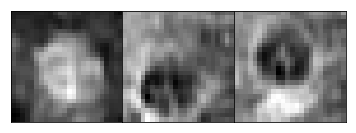

In [100]:
img = drm.plot_check(2, "E100810603", normalize=None)
print(np.amin(img), np.amax(img), np.mean(img))

In [ ]:
for cls in C.classes_to_include:
    print(cls)
    print('\n'.join([x[:-4] for x in os.listdir("E:\\lesion_imgs_small\\"+cls)]))
    #vm.save_vois_as_imgs(cls=cls, save_dir="E:\\lesion_imgs_small\\"+cls, fn_suffix="")

In [294]:
lids = ['E106097391_0.npy', 'E104978772_1.npy', '12900535_0.npy', 'E100150242_0.npy', 'E105490014_0.npy', 'E103147618_0.npy', 'E103510187_0.npy', 'E104657225_0.npy', 'E100551966_0.npy', 'E101388602_0.npy', 'E100215900_8.npy', 'E100215900_7.npy', 'E104045692_0.npy', '13104521_0.npy', 'E100383453_0.npy', '12943286_0.npy', '12271995_0.npy', 'E102315724_0.npy', 'E104949189_0.npy', 'E100511083_1.npy', 'E101579471_0.npy', '13018986_1.npy', '13203550_8.npy', '13112385_0.npy', '12712463_0.npy', '12361082_0.npy', '13028374_0.npy', 'E103985934_1.npy', 'E100529980_0.npy', '12042703_3.npy', '12961059_0.npy', 'E105724706_2.npy', 'E100592424_2.npy', 'E103104254_0.npy', 'E104546069_0.npy', 'E101665217_1.npy', '12090000_0.npy', 'E100592424_1.npy', '12961059_1.npy', 'E105474285_0.npy', '12502068_1.npy', 'E100814791_0.npy', 'E102613189_0.npy', 'E105427046_0.npy', 'E102881031_1.npy', 'E102929168_0.npy', 'E102310482_0.npy', 'E102095465_0.npy', 'E101811299_0.npy', 'E104737273_0.npy', '12890053_0.npy', 'E100168661_1.npy', '12637865_0.npy', 'E100168661_2.npy', '12239783_0.npy', '12707781_0.npy', '12706568_1.npy', '12823036_0.npy', '12404081_0.npy', '12365693_1.npy']

In [301]:
lids = ['13018986_1', '13203550_8', 'E100168661_1', '12706568_1', 'E104189184_0', 'E100215900_7', '12900535_0', 'E100551966_0',
       'E102310482_0', 'E102095465_0', 'E105474285_0', 'E105724706_2']

In [32]:
misclass_img = ['E100610622_0', '12788616_0', '13092836_2', 'E100407633_0', 'E103312835_1', 'E103020139_1']

In [ ]:
vm.save_imgs_with_bbox(lesion_ids=misclass_img, save_dir="E:\\Z_test", separate_by_cls=False)

In [33]:
vm.save_vois_as_imgs(lesion_ids=misclass_img, save_dir="E:\\Z_test_small", separate_by_cls=False)

# Generate reader study samples

In [24]:
voi_df_art, voi_df_ven, voi_df_eq = drm.get_voi_dfs()

In [120]:
Z_reader = ['E103312835_1','12823036_0','12569915_0','E102093118_0','E102782525_0','12799652_0','E100894274_0','12874178_3','E100314676_0','12842070_0','13092836_2','12239783_0','12783467_0','13092966_0','E100962970_0','E100183257_1','E102634440_0','E106182827_0','12582632_0','E100121654_0','E100407633_0','E105310461_0','12788616_0','E101225606_0','12678910_1','E101083458_1','12324408_0','13031955_0','E101415263_0','E103192914_0','12888679_2','E106096969_0','E100192709_1','13112385_1','E100718398_0','12207268_0','E105244287_0','E102095465_0','E102613189_0','12961059_0','11907521_0','E105311123_0','12552705_0','E100610622_0','12975280_0','E105918926_0','E103020139_1','E101069048_1','E105427046_0','13028374_0','E100262351_0','12302576_0','12451831_0','E102929168_0','E100383453_0','E105344747_0','12569826_0','E100168661_0','12530153_0','E104697262_0']

banned_accnums = [z[:z.find('_')] for z in Z_reader]

voi_reader = voi_df_art[voi_df_art["id"].isin(Z_reader)]#voi_df_art[voi_df_art.index.isin(Z_reader)]

In [260]:
f_map = {}
b_map = {}
cls_map = {}

for cls in C.classes_to_include:
    for index, row in voi_reader[voi_reader['cls'] == cls].iterrows():
        img_id = str(sum([row["x1"], row["x2"], row["y1"], row["y2"]])*10+row["z1"])
        acc_num = row["Filename"][:-4] #row["acc_num"]
        f_map[row["id"]] = img_id
        b_map[img_id] = row["id"]#acc_num
        cls_map[row["id"]] = row["cls"]#acc_num
        #if cls == "fnh":#img_id == "4613":
        print("Z:\\DICOMs\\" + cls + "\\" + acc_num, 
              row["x1"], row["x2"], row["y1"], row["z1"], "---", img_id)
        try:
            print(b_map[img_id])
        except:
            pass

#f_map['E100199185'] = '46130'
#b_map['4613'] = "12678910_1"
#b_map['46130'] = "E100199185_0"

In [262]:
with open('Z:\\answer_key.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for k in Z_reader:
        writer.writerow([k, f_map[k], cls_map[k]])

In [ ]:
hitlist = []
replacements = []

for secret_id in ['4181', '2858', '3505', '4194', '2821', '5912', '5047'] + ['4354', '3049', '5438'] + ['46130']:#['4158', '5720', '46130', '7444']:
    print(cls_map[b_map[secret_id]])
    hitlist.append(b_map[secret_id])
    replacements.append(cls_map[b_map[secret_id]])

In [165]:
for secret_id in ['4181', '2858', '3505', '4194', '2821', '5912', '5047']:
    base_dir = r"Z:\Inter-reader study\DICOMs"
    shutil.move(os.path.join(base_dir, secret_id), os.path.join(base_dir, "Unused", secret_id))

In [33]:
multi_accnums = [accnum for accnum, count in zip(*np.unique(list(b_map.values()), return_counts=True)) if count>1]
print(multi_accnums)

In [276]:
for _, row in voi_reader.iterrows():
    cls = row["cls"]
    acc_num = str(row["Filename"])[:-4]
    for protocol in ["T1_AP", "T1_VP", "T1_EQ"]:
        target_dir = os.path.join("Z:\\Inter-reader study\\DICOMs\\extras", row['id'], protocol)
        shutil.copytree(os.path.join("Z:\\DICOMs", cls, acc_num, protocol), target_dir)

In [ ]:
for acc_num in f_map:
    try:
        os.rename(os.path.join("Z:\\Inter-reader study\\DICOMs", acc_num),
                  os.path.join("Z:\\Inter-reader study\\DICOMs", f_map[acc_num]))
    except Exception as e:
        print(acc_num, e)

# Read Run Stats

In [24]:
a = ['12823036_0','12799652_0','12874178_3','12842070_0','12239783_0','E100121654_0','12788616_0','12678910_1','11907521_0','E100168661_0']

In [26]:
[x for x in sorted_x if x[0][:-4] in a]

[('12788616_0.npy', 4),
 ('12823036_0.npy', 3),
 ('12678910_1.npy', 2),
 ('E100168661_0.npy', 1),
 ('12239783_0.npy', 1),
 ('12842070_0.npy', 1),
 ('E100121654_0.npy', 1),
 ('12799652_0.npy', 1),
 ('12874178_3.npy', 1),
 ('11907521_0.npy', 1)]

In [23]:
df = pd.read_csv(C.run_stats_path)

df = df.dropna(subset=['misclassified_test'])
df = df.loc[:,['misclassified_test','misclassified_train']]
#df = df.dropna()
#b = a.iloc[0]['y_pred_raw']
#b = hf.str_to_lists(b)

mis_test = df['misclassified_train'].values
mis_test += df['misclassified_test'].values

mis_test = ''.join(mis_test)
mis_test = mis_test.replace(' ','')
mis_test = mis_test.replace("'","")
mis_test = re.sub(r'\]\[', ',', mis_test)
mis_test = mis_test.replace("[","")
mis_test = mis_test.replace("]","")

mis_test = mis_test.split(',')

unique, counts = np.unique(mis_test, return_counts=True)

x = dict(zip(unique, counts))

sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)
sorted_x

[('', 29),
 ('12324408_0.npy', 11),
 ('E100815255_1.npy', 11),
 ('12917515_0.npy', 10),
 ('E105427046_0.npy', 10),
 ('13094833_0.npy', 9),
 ('13147226_1.npy', 9),
 ('E101415263_0.npy', 9),
 ('E100592424_2.npy', 8),
 ('13260276_0.npy', 7),
 ('E102860472_1.npy', 7),
 ('E103418455_0.npy', 7),
 ('12631540_0.npy', 7),
 ('12362250_6.npy', 7),
 ('12569915_0.npy', 7),
 ('E103192914_0.npy', 7),
 ('E101544573_0.npy', 6),
 ('12975280_0.npy', 6),
 ('12814666_2.npy', 6),
 ('E101083458_0.npy', 6),
 ('13147226_2.npy', 6),
 ('E101166449_0.npy', 6),
 ('E100962970_0.npy', 6),
 ('E102677567_1.npy', 5),
 ('E100168424_0.npy', 5),
 ('12831275_1.npy', 5),
 ('E103359656_0.npy', 5),
 ('E102677567_3.npy', 5),
 ('13031955_0.npy', 5),
 ('E101083458_2.npy', 5),
 ('11534565_0.npy', 5),
 ('E100207768_0.npy', 5),
 ('12960946_0.npy', 5),
 ('E104406701_0.npy', 4),
 ('E102307147_0.npy', 4),
 ('E100383453_0.npy', 4),
 ('12788616_0.npy', 4),
 ('E101179822_1.npy', 4),
 ('13109809_0.npy', 4),
 ('E104099180_0.npy', 4),
 ('12

In [3]:
df = pd.read_csv(C.run_stats_path)
df = df[(df['test_num'] == 10) & (~df['time_dist']) & (df['steps_per_epoch'] == 750) & (df['timestamp'] < 1515879326)]

In [18]:
np.mean(df['acc6cls'])

0.91916666660000002

In [21]:
train_acc = [1-x.count("npy")/434 for x in df['misclassified_train'].values]

In [4]:
cms = df['confusion_matrix'].values

cms = ''.join(cms)

ret = hf.str_to_lists(cms, dtype=int)

supercm = ret

supercm = [supercm[rownum:rownum+6] for rownum in range(0,len(supercm),6)]

supercm = np.array(supercm)

cm_sum = np.empty((6,6))

for i in range(6):
    for j in range(6):
        cm_sum[i,j] = np.sum(supercm[:,i,j])

for i in range(6):
    for j in range(6):
        print(cm_sum[j,i],end='\t')
    print()

187.0	4.0	1.0	0.0	0.0	11.0	
1.0	180.0	18.0	0.0	10.0	6.0	
3.0	6.0	177.0	3.0	7.0	0.0	
0.0	0.0	1.0	197.0	2.0	0.0	
1.0	2.0	3.0	0.0	181.0	2.0	
8.0	8.0	0.0	0.0	0.0	181.0	


In [5]:
np.sum(cm_sum[0,:])-187

13.0

In [6]:
avg_tpr = cm_sum[0,0]/np.sum(cm_sum[0,:])
avg_fpr = np.sum(cm_sum[1:,0])/np.sum(cm_sum[1:,:])

In [7]:
fpr = [np.sum(cm[1:,0])/np.sum(cm[1:,:]) for cm in supercm]
tpr = [cm[0,0]/np.sum(cm[0,:]) for cm in supercm]

In [8]:
truths = df['y_true'].values
truths = ''.join(truths)
truths = hf.str_to_lists(truths, dtype=int)
truths = np.array(truths)

predictions = df['y_pred_raw'].values
predictions = ''.join(predictions)
predictions = hf.str_to_lists(predictions, dtype=float)
predictions = [predictions[rownum:rownum+60] for rownum in range(0,len(predictions),60)]
predictions = np.array(predictions)

hcc_thresh = []
nonhcc_thresh = []
thresh_dict = {}

for run_num in range(20):
    for lesion_num in range(60):
        if truths[run_num, lesion_num] == C.classes_to_include.index('hcc'):
            hcc_thresh.append(predictions[run_num, lesion_num, 0])
            thresh_dict[predictions[run_num, lesion_num, 0]] = 'hcc'
        else:
            nonhcc_thresh.append(predictions[run_num, lesion_num, 0])
            thresh_dict[predictions[run_num, lesion_num, 0]] = 'non-hcc'

In [9]:
TPR = [200/200]
FPR = [1000/1000]

hcc_correct = 200
hcc_wrong = 1000
for key in sorted(thresh_dict):
    if thresh_dict[key] == 'hcc':
        hcc_correct -= 1
    else:
        hcc_wrong -= 1
    TPR.append(hcc_correct/200)
    FPR.append(hcc_wrong/1000)

In [10]:
avg_fpr, avg_tpr

(0.016, 0.93500000000000005)

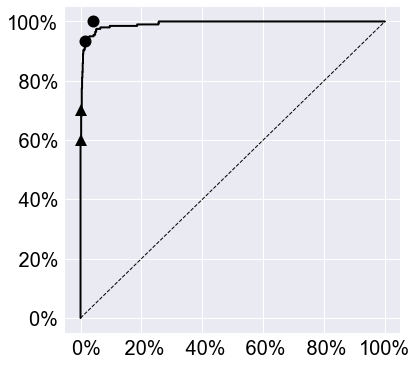

In [14]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,1,figsize=(6, 6))
ax.plot(FPR, TPR, 'k', label='Model', linewidth=2)
ax.plot(.04, 1, 'ko', label='ModelReader', markersize=12)
ax.plot(0, .7, 'k^', label='RAD2', markersize=12)
ax.plot(0, .6, 'k^', label='RAD1', markersize=12)
ax.plot(avg_fpr, avg_tpr, 'ko', label='ModelAvg', markersize=12)
#ax.plot(fpr, tpr, 'o', ms=5)
ax.plot([0,1], [0,1], 'k--', lw=1)
vals = ax.get_xticks()
ax.set_xticklabels(['{:3.0f}%'.format(x*100) for x in vals], size=20, color='k')
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals], size=20, color='k')

#ax.xaxis.set_major_formatter(plt.FuncFormatter('{:.0f}%'.format))
#ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.0f}%'.format))

In [56]:
sp.plot(FPR, TPR, 'k', label='Model', linewidth=3)
sp.plot(.1, .9, 'g^', label='Model', markersize=10)
sp.plot(.43, 1., 'r^', label='R2', markersize=10)
sp.plot(.67, 1., 'b^', label='R1', markersize=10)

In [37]:
AUC = sum([(FPR[i]-FPR[i+1])*TPR[i] for i in range(len(FPR)-1)])
AUC

0.9922300000000035

a = run_stats.loc[:,['y_true','y_pred_raw']]
a = a.dropna()
b = a.iloc[0]['y_pred_raw']
b = hf.str_to_lists(b)

# Artificial images

In [ ]:
agm.gen_imgs()
img = agm.visualize_gen_img('hemangioma')